# Music recommender system

One of the most used machine learning algorithms is recommendation systems.  
  
A **recommender** (or recommendation) **system** (or engine) is a filtering system which aim is to predict a rating or preference a user would give to an item, eg. a film, a product, a song, etc.

There are two main types of recommender systems: 
- Content-based filters
- Collaborative filters
  
However,  nowadays a combination of both approaches is used. In this project, we'll go through the steps for generating a music recommender system.

## Importing required libraries

First, we'll import all the required libraries.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Reading the files

We are going to use the **[Million Song Dataset](http://millionsongdataset.com/)**, a freely-available collection of audio features and metadata for a million contemporary popular music tracks. 

There are two files that will be interesting for us. The first of them will give us information about the songs. Particularly, it contains the user ID, song ID and the listen count. On the other hand, the second file will contain song ID, title of that song, release, artist name and year. 
We need to merge these two DataFrames. For that aim, we'll use the `song_ID` 

In [2]:
#Read userid-songid-listen_count triplets
#This step might take time to download data from external sources
song_info_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_info = pd.read_csv(song_info_file,sep='\t',header=None)
song_info.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_actual =  pd.read_csv(songs_file)

#Merge the two dataframes above to create input dataframe for recommender systems
songs = pd.merge(song_info, song_actual.drop_duplicates(['song_id']), on="song_id", how="left")

## Exploring the data

As usual, any data science or machine learning project starts with an exploratory data analysis (EDA). The aim of EDA is to understand and get insights on our data.

We'll first inspect the first rows of our `DataFrame`.

In [39]:
#Explore first rows
songs.head()

,user_id,song_id,listen_count,title,release,artist_name,year,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,The Cove-Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,Entre Dos Aguas-Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,Stronger-Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005,Constellations-Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,Learn To Fly-Foo Fighters


Then, we'll check how many observions there are in the dataset.

In [63]:
#Get total observations
print(f"There are {songs.shape[0]} observations in the dataset")

There are 2000000 observations in the dataset


Now, we should perform some cleaning steps. But looking at the dataset, we can see that there is no missing values.

In [81]:
songs.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
song            0
dtype: int64

And most of the columns contain strings.

In [82]:
songs.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
song            object
dtype: object

Let's start exploring some characteristics of the dataset: 

- Unique songs:

In [65]:
#Unique songs
print(f"There are {songs['title'].unique().shape[0]} unique songs in the dataset")

There are 9567 unique songs in the dataset


- Unique artists:

In [66]:
#Unique artists
print(f"There are {songs['artist_name'].unique().shape[0]} unique artists in the dataset")

There are 3375 unique artists in the dataset


- Unique users:

In [67]:
#Unique users
print(f"There are {songs['user_id'].unique().shape[0]} unique songs in the dataset")

There are 76353 unique songs in the dataset


We'll go ahead and explore the popularity of songs and artists.

### Most popular songs

How do we determine which are the most popular songs? For this task, we'll count how many times each song appears. Note that while we are using  `listen_count`, we only care about the number of rows, we don't consider the number present in that row. This number represents how many times one user listen to the same song.

In [78]:
#count how many rows we have by song, we show only the ten more popular songs 
songs.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending = [0,1])[:10]

,title,listen_count
6836,Sehr kosmisch,8277
8725,Undo,7032
1964,Dog Days Are Over (Radio Edit),6949
9496,You're The One,6729
6498,Revelry,6145
6825,Secrets,5841
3437,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385
2595,Fireflies,4795
3322,Hey_ Soul Sister,4758
8494,Tive Sim,4548


### Most popular artist

For the next task, we'll count how many times each artist appears. Again, we'll count how many times the same artist appears.

In [85]:
#count how many rows we have by artist name, we show only the ten more popular artist 
ten_pop_artists  = songs.groupby(['artist_name'])['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], 
                                                                                                ascending = [0,1])[:10]

In [86]:
ten_pop_artists

,artist_name,listen_count
649,Coldplay,29422
2850,The Black Keys,19862
1651,Kings Of Leon,18747
1107,Florence + The Machine,18112
1370,Jack Johnson,17801
2946,The Killers,16063
2374,Radiohead,14890
736,Daft Punk,14715
2073,Muse,14005
1554,Justin Bieber,13959


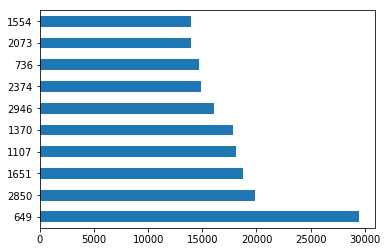

In [87]:
ten_pop_artists['listen_count'].plot(kind='barh')

### Listen count by user

We can also get some other information from the feature `listen_count`. We will answer the folloging questions:

**How many times on average the same user listen to a same song?**

In [79]:
print(f"On average, a user listen to the same song {songs['listen_count'].mean()} times")

On average, a user listen to the same song 3.0454845 times


**What was the maximum times the same user listen to a same song?**

In [80]:
print(f"The maximum times the same user listened to the same songs was as follows:")
songs.sort_values('listen_count', ascending=False)[['title',  'listen_count']][:10]

The maximum times the same user listened to the same songs was as follows:


,title,listen_count
1228366,Starshine,2213
1048310,Crack Under Pressure,920
1586780,Call It Off (Album Version),879
31179,Paradise & Dreams,796
1875121,You're The One,683
1644909,I'm On A Boat,676
1731945,Dance_ Dance,664
1374693,Reelin' In The Years,649
1819571,Can't Help But Wait (Album Version),605
515442,The Quest,585


So, we know that we want to predict songs. So, in order to have all the information in only one column, we'll concatenate the song `title` with the `artist_name`. We'll assign the resultant string to the new column `song`.

In [38]:
#Concatenate title and artist name. Assign it to new columns
songs['song'] = songs['title'] + "-" + songs["artist_name"]